## Problem statement:
Build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow==2.12


In [3]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [5]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Data Visualization**

Found 6739 files belonging to 9 classes.


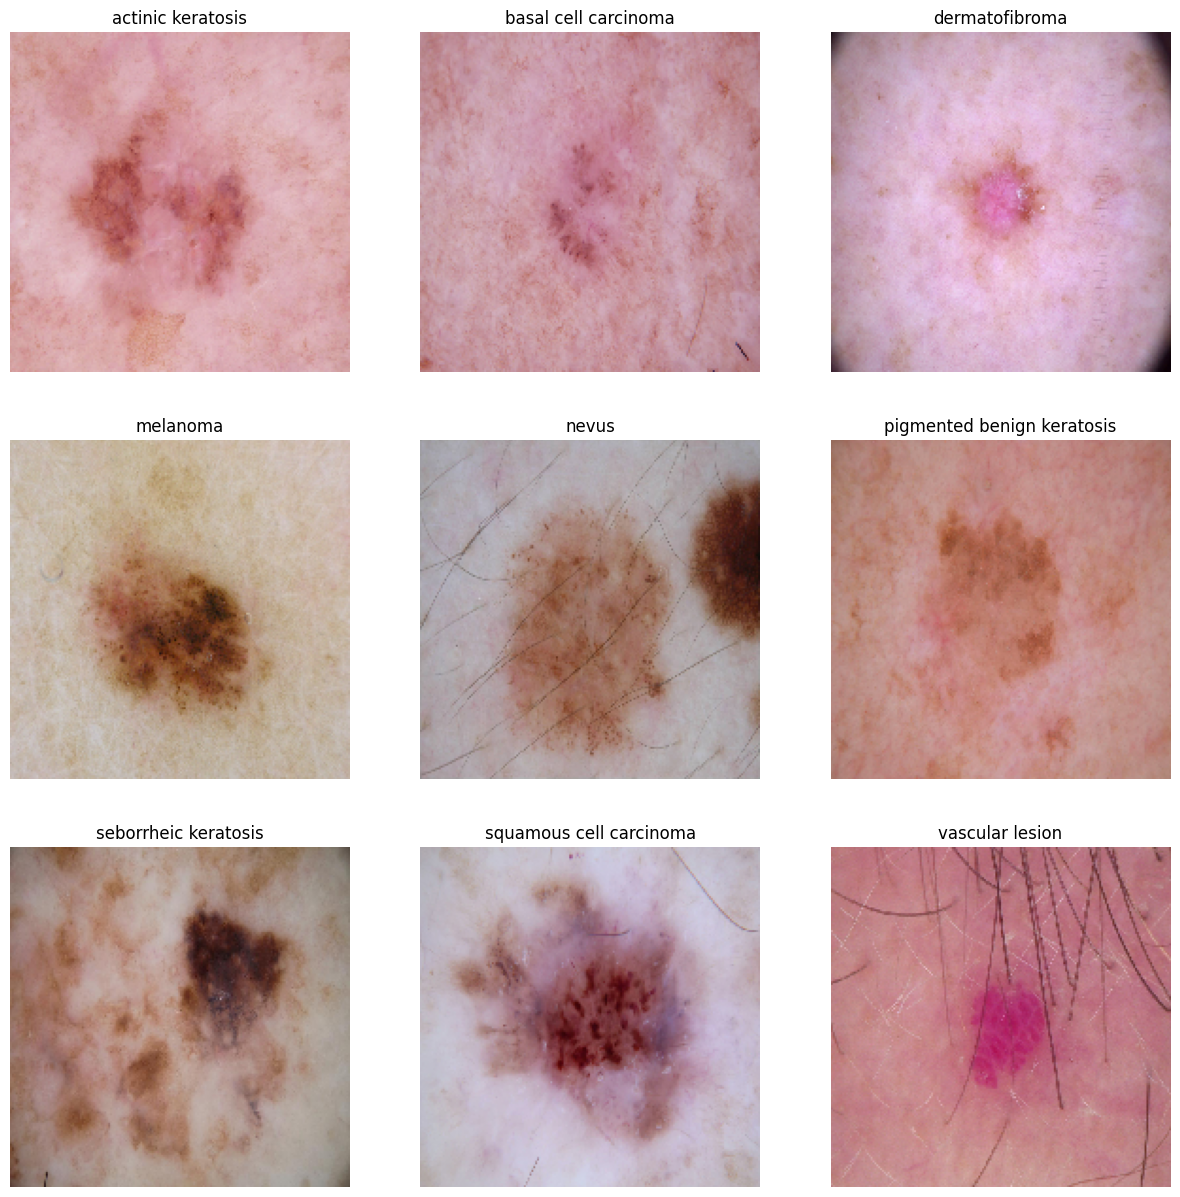

In [6]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

**Visualize distribution of classes in the training dataset.**

In [7]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,squamous cell carcinoma,181
2,nevus,357
3,seborrheic keratosis,77
4,dermatofibroma,95
5,vascular lesion,139
6,basal cell carcinoma,376
7,melanoma,438
8,pigmented benign keratosis,462


<Axes: xlabel='No. of Image', ylabel='Class'>

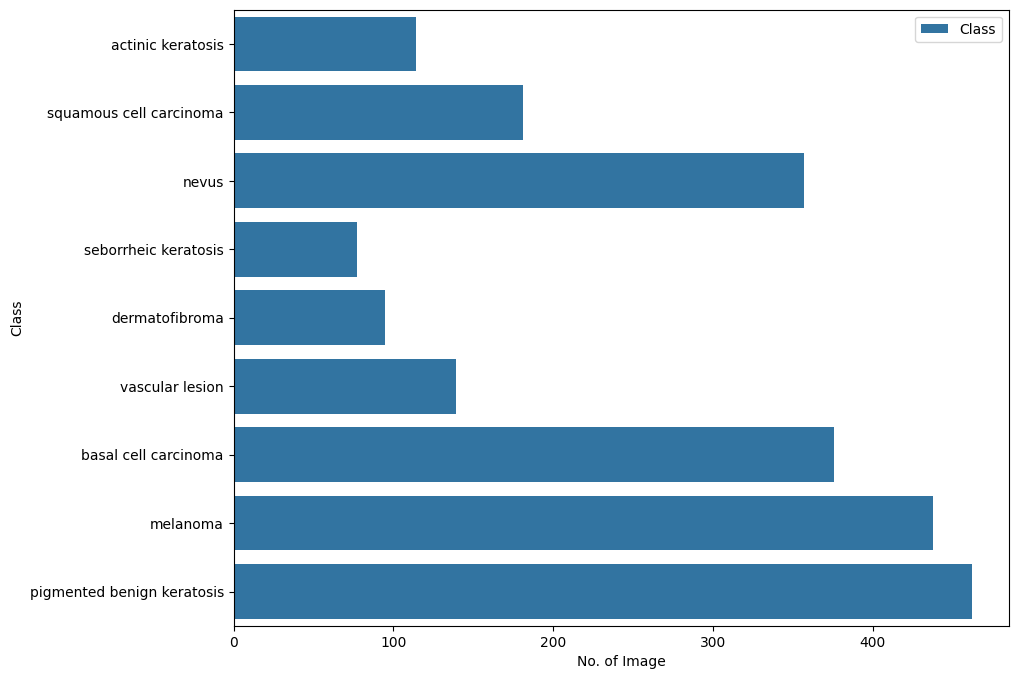

In [8]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

There is a class imbalance to solve this using a python package  Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [9]:
#install Augmentor
!pip install Augmentor

In [10]:
import os  # Ensure os module is imported

# Define the dataset path (Replace with your actual dataset path)
path_to_training_dataset = "/content/drive/MyDrive/CNN_assignment"

# Debugging: Print the variable to check if it's defined
print("Dataset path:", path_to_training_dataset)

# Check if the dataset path exists
if not os.path.exists(path_to_training_dataset):
    raise ValueError(f"Error: The dataset path '{path_to_training_dataset}' does not exist. Check your path.")



Dataset path: /content/drive/MyDrive/CNN_assignment


In [11]:
import os
import Augmentor

# Verify dataset path
if not os.path.exists(path_to_training_dataset):
    raise ValueError(f"Error: The dataset path '{path_to_training_dataset}' does not exist. Check your path.")

for i in class_names:
    folder_path = os.path.join(path_to_training_dataset, i)

    if not os.path.exists(folder_path):
        print(f"Skipping {i} - Directory does not exist.")
        continue  # Skip this class if the folder is missing

    p = Augmentor.Pipeline(folder_path)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  # Adding 500 samples per class


Skipping actinic keratosis - Directory does not exist.
Skipping basal cell carcinoma - Directory does not exist.
Skipping dermatofibroma - Directory does not exist.
Skipping melanoma - Directory does not exist.
Skipping nevus - Directory does not exist.
Skipping pigmented benign keratosis - Directory does not exist.
Skipping seborrheic keratosis - Directory does not exist.
Skipping squamous cell carcinoma - Directory does not exist.
Skipping vascular lesion - Directory does not exist.


In [12]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Model Building**

In [13]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [14]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [15]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
!pip install keras==2.3.1 # Or another suitable version with the 'experimental' namespace

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.8/377.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires keras<2.13,>=2.12.0, but you have keras 2.3.1 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.12.0 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.12.0 which is incompatible.


In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pathlib  # Import pathlib

# Assuming data_dir_train is defined and contains the path to your training data
data_dir_train = pathlib.Path("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")  # Replace with your actual path
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='categorical',  # Use 'categorical' for one-hot encoding
    image_size=(180, 180),
    interpolation='nearest',
    batch_size=32,
    shuffle=True
)
class_names = image_dataset.class_names  # Get class names from the dataset


# Create a Sequential model
model = models.Sequential()

# Rescaling Layer - Corrected import path
model.add(layers.Rescaling(1./255, input_shape=(180, 180, 3)))

# First Convolutional Layer
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# Second Convolutional Layer
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# Third Convolutional Layer
model.add(layers.Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# Dropout Layer
model.add(layers.Dropout(0.5))

# Flatten Layer
model.add(layers.Flatten())

# Dense Layer
model.add(layers.Dense(128, activation='relu'))

# Dropout Layer
model.add(layers.Dropout(0.25))

# Make sure `class_names` is defined before using it
# Example: class_names = ['cat', 'dog', 'horse']
num_classes = len(class_names)  # Define this variable correctly

# Dense Layer with softmax activation
model.add(layers.Dense(num_classes, activation='softmax'))

# Display the model summary
model.summary()


Found 6739 files belonging to 9 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv

In [18]:
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)


TensorFlow Version: 2.12.0


In [19]:
!pip install --upgrade tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 69.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12.3:
      Successfully uninstalled tensorboard-2.12.3
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found 

In [20]:
!pip install tensorflow==2.12

  Using cached tensorflow-2.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached keras-2.12.0-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
  Using cached tensorboard-2.12.3-py3-none-any.whl.metadata (1.8 kB)
Using cached tensorflow-2.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (586.0 MB)
Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
Using cached tensorboard-2.12.3-py3-none-any.whl (5.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
  Attempting uninstall: keras
    Found existing installation: keras 3.9.0
    Uninstalling keras-3.9.0:
      Successfully uninstalled keras-3.9.0
  Attempting uninstall: tensorboard
    Fou

In [1]:
!pip install pydot graphviz


In [2]:
import tensorflow as tf
import pathlib

# Define the dataset path (Change this to your actual dataset directory)
data_dir_train = "/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"

# Convert to pathlib Path (Recommended)
data_dir_train = pathlib.Path(data_dir_train)

# Create image dataset
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size=(180, 180),  # Adjust based on your model input
    batch_size=32,          # Adjust as needed
    shuffle=True
)

# Extract class names
class_names = image_dataset.class_names

print("Class Names:", class_names)


Found 6739 files belonging to 9 classes.
Class Names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [3]:
print("Dataset Path:", data_dir_train)


Dataset Path: /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train


In [4]:
import os
print("Path Exists:", os.path.exists(data_dir_train))


Path Exists: True


In [5]:
import os
data_dir_train = os.path.abspath("dataset/train")
print("Absolute Path:", data_dir_train)


Absolute Path: /content/dataset/train


In [6]:
import os

data_dir_train = "/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"  # Your dataset path

if os.path.exists(data_dir_train):
    print("✅ Directory found:", data_dir_train)
else:
    print("❌ Directory NOT found! Check the path.")



✅ Directory found: /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train


In [7]:
import tensorflow as tf
import pathlib

# Convert to pathlib Path (Recommended)
data_dir_train = pathlib.Path("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")

# Load dataset
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size=(180, 180),  # Adjust as needed
    batch_size=32,
    shuffle=True
)

# Extract class names
class_names = image_dataset.class_names
print("Class Names:", class_names)


Found 6739 files belonging to 9 classes.
Class Names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Helps prevent overfitting
    layers.Dense(3, activation='softmax')  # Assuming 3 classes
])

# Compile the model
model.compile(optimizer="Adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# ModelCheckpoint callback - saves the best model based on validation accuracy
checkpoint = ModelCheckpoint("model.h5",
                             monitor="val_accuracy",
                             save_best_only=True,
                             mode="auto",
                             verbose=1)

# EarlyStopping callback - stops training if validation accuracy stops improving
earlystop = EarlyStopping(monitor="val_accuracy",
                          patience=5,
                          mode="auto",
                          verbose=1)

In [9]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
!ls "/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration"


Test  Train


In [11]:
!ls "/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration"


Test  Train


In [12]:
!ls "/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Validation"


ls: cannot access '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Validation': No such file or directory


In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define dataset paths
data_dir_train = "/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
data_dir_test = "/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test"

# Load datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical'  # One-hot encoding for categorical crossentropy
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical'  # One-hot encoding for categorical crossentropy
)

# Get number of classes
num_classes = len(train_ds.class_names)

# Create a new model (or modify an existing one)
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Helps prevent overfitting
    layers.Dense(num_classes, activation='softmax')  # Ensure output matches number of classes
])

# Compile model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Set up model checkpoint & early stopping
checkpoint = tf.keras.callbacks.ModelCheckpoint("model.h5", save_best_only=True, monitor="val_accuracy", mode="max")
earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, mode="max")

# Train the model
epochs = 4
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[checkpoint, earlystop])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 6739 files belonging to 9 classes.
Found 118 files belonging to 9 classes.
Epoch 1/4
211/211 [==============================] - 1078s 5s/step - loss: 16.0357 - accuracy: 0.1695 - val_loss: 2.1688 - val_accuracy: 0.1949
Epoch 2/4
211/211 [==============================] - 655s 3s/step - loss: 2.1447 - accuracy: 0.1899 - val_loss: 2.4023 - val_accuracy: 0.1525
Epoch 3/4
211/211 [==============================] - 638s 3s/step - loss: 1.9916 - accuracy: 0.2457 - val_loss: 2.6684 - val_accuracy: 0.1949
Epoch 4/4
211/211 [==============================] - 625s 3s/step - loss: 1.9096 - accuracy: 0.2738 - val_loss: 2.5896 - val_accuracy: 0.1441


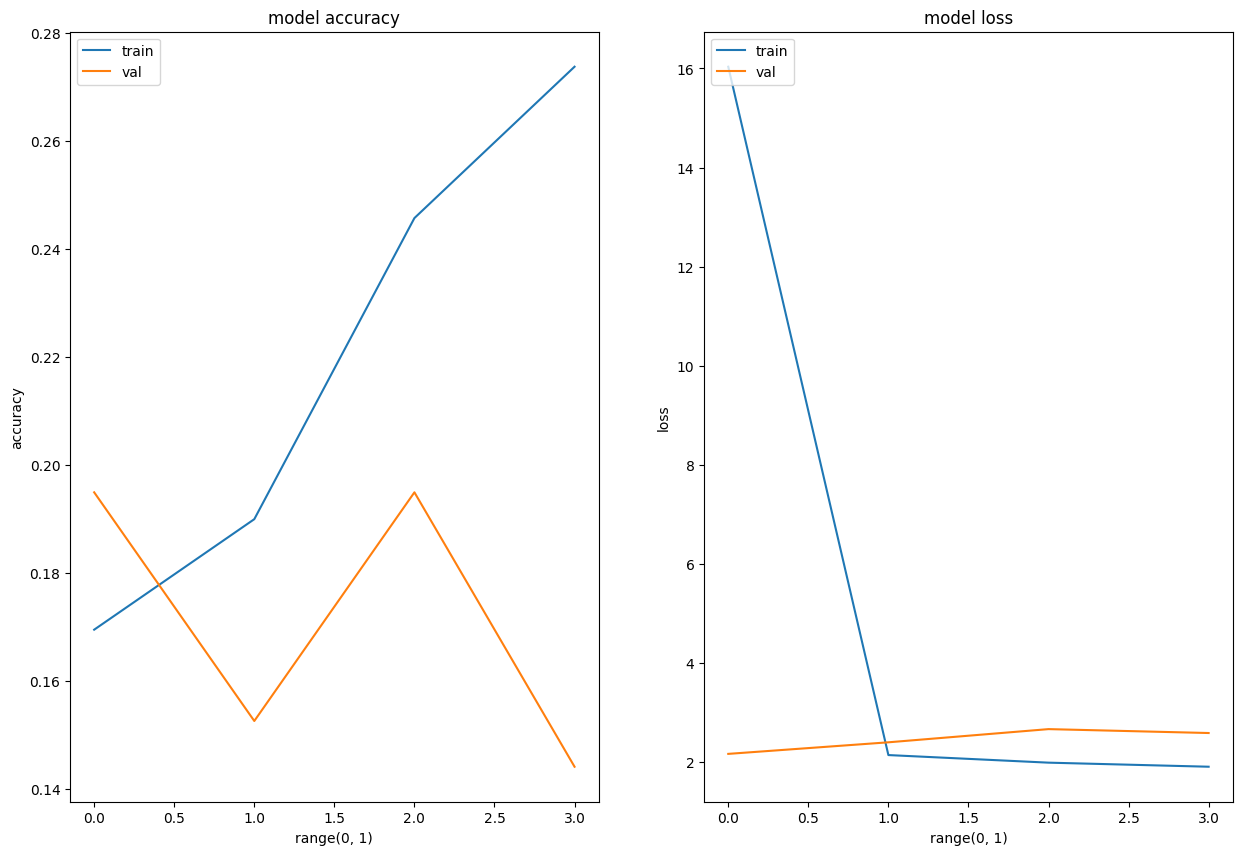

In [16]:
# Plot the training curves
import matplotlib.pyplot as plt

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## Model Prediction

1/1 [==============================] - 0s 229ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


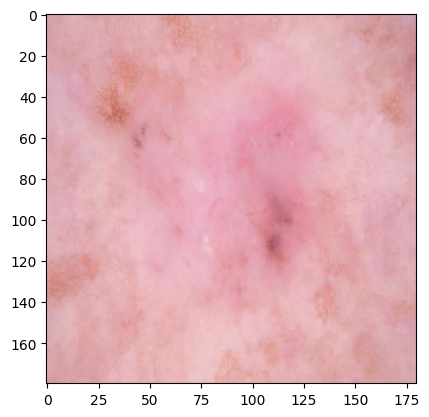

In [17]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img # Import load_img
import numpy as np # Import numpy

Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

In [18]:
!pip install tensorflow==2.18.0 keras==3.8.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 842.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 95.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12.3:
      Successfully uninstalled tensorboard-2.12.3
  Attempting uninstall: ml-dtypes
    Found existing installation: ml_dtypes 0.5.1
    Uninstalling ml_dtypes-0.5.1:
      Successfully uninstalled ml_dtypes-0.5.1
  Attempting uninstall: keras
    Foun

In [3]:
# Define the model
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Helps prevent overfitting
    layers.Dense(3, activation='softmax')  # Assuming 3 classes
])

# Compile the model
model.compile(optimizer="Adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# (Optional) Train the model if you haven't already
# ... your training code here ...

# Now you can save the model
model.save("models/SkinCancer_Detection.h5")
from tensorflow import keras

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
# OR save in legacy `.h5` format for compatibility
model.save("models/SkinCancer_Detection.h5")
from tensorflow import keras

In [5]:
# OR load `.h5` model (for older versions)
model = keras.models.load_model("models/SkinCancer_Detection.h5")